In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)

In [91]:
class Network:
    """
    Network class used to solve the second exercise of assignment 1b.
    
    Arguments
    ---------
    sizes: list. First entry should be the # of variables in X, last entry 
        should be the number of classes to predict. 
    """
    def __init__(self, sizes, activation_fun):
        """
        num_layers : int, number of layers in the network, not including the input
        b, W : [np.array]
        m,v : [np.array], used in the ADAM updates
        activation_fun : str or [str], specifies the activation functions to be used
            in each layer of the network. AssertionError if the num_layers != len(.)
        """
        self.num_layers = len(sizes) - 1
        self.sizes = sizes
        
        # weight matricies
        self.b = [np.random.rand(y, 1)*.1 for y in sizes[1:]]
        self.W = [np.random.randn(y, x)*.1 for x, y in zip(sizes[:-1], sizes[1:])]
        
        if len(sizes) > 2 and isinstance(activation_fun, str):
            self.activation_fun = [activation_fun] * self.num_layers
        elif isinstance(activation_fun, list):
            self.activation_fun = activation_fun
            assert(len(activation_fun) == len(sizes) - 2)
        elif len(sizes) == 1 and isinstance(activation_fun, str):
            self.activation_fun = [activation_fun]
            
    ### Methods for the activation functions ###
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def relu(self, z):
        return np.maximum(z, 0)
    
    def softmax(self, z):
        """
        Uses stabilization by subtracting the max in the exponent
        """
        s = np.max(z, axis=1).reshape(z.shape[0], 1)
        e_x = np.exp(z - s)
        return e_x / np.sum(e_x, axis=1).reshape(z.shape[0], 1)
    
    ###  forward propagation ###
    def linear_forward(self, h_prev, W, b):
        """
        Computes the linear transformation at layer l
        
        Arguments
        ---------
        
        """
        return h_prev.dot(W.T) + b.T
    
    def activation_forward(self, h_prev, W, b, activation_fun):
        if activation_fun == "sigmoid":
            Z = self.linear_forward(h_prev, W, b)
            h = self.sigmoid(Z)
        
        elif activation_fun == "relu":
            Z = self.linear_forward(h_prev, W, b)
            h = self.relu(Z)
            
        elif activation_fun == "softmax":
            Z = self.linear_forward(h_prev, W, b)
            h = self.softmax(Z)
            
        return h, Z
    
    def model_forward(self, X):
        """
        Forward propagation with softmax output
        """
        activation_cache = [X]
        z_cache = []
        
        # i = 1, ... , L-1
        for i in range(self.num_layers-1):
            h_new, z_new = self.activation_forward(
                activation_cache[i], self.W[i], self.b[i], self.activation_fun[i])
            activation_cache.append(h_new)
            z_cache.append(z_new)
        
        # output layer
        h_L, z_L = self.activation_forward(activation_cache[-1], self.W[-1], self.b[-1], "softmax")
        activation_cache.append(h_L)
        z_cache.append(z_L)
        
        return activation_cache, z_cache
    
    ### Cost function ###
    def compute_cost(self, h_L, y):
        """
        Computes the cross entropy loss
        
        Arguments
        ---------
        h_L : np.array, output from final layer
        y : np.array, one-hot encoded class labels
        """
        return (-1 / y.shape[0]) * np.sum(y * np.log(h_L))
    
    ### Derivatives used ###
    def cost_derivative(self, h_L, y):
        """
        Based on the calculated derivative of the cross-entropy cross function
        
        Arguments
        h_L : np.array, final element of activation_cache
        y : np.array, one-hot encoded classes
        """
        return h_L - y
    
    def sigmoid_grad(self, z):
        """
        Compute gradient of sigmoid function wrt to the input
        
        Arguments
        z : np.array, linear transformation of the previous layers output
        """
        h = self.sigmoid(z)
        return h * (1-h)
    
    def relu_grad(self, z):
        """
        Compute gradient of relu function wrt to the input
        
        Arguments
        z : np.array, linear transformation of the previous layers output
        """
        h = self.relu(z)
        return np.int64(h > 0)
    
    ### Backpropagation ###
    def linear_backward(self, g, h_prev, W, b):
        """
        Computes gradient wrt to the weights, offset and hidden output
        from the previous layer
        
        Arguments
        g : np.array, following the notation from lecture 3, g is the 
            gradient of the cost function
        """
        dW = g.T.dot(h_prev)
        db = g.mean(axis = 0).reshape(b.shape)
        dh_prev = g.dot(W)
        
        # dimensions should be the same 
        assert dh_prev.shape == h_prev.shape, "ERROR: h_prev.shape != dh_prev.shape"
        assert dW.shape == W.shape, "ERROR: dW.shape != W.shape"
        assert db.shape == b.shape, "ERROR: db.shape != b.shape"
        
        return dh_prev, dW, db
    
    def linear_activation_backward(self, g, z, activation_fun):
        """
        (a) step in step 2. of the pseudo-code for L3.
        
        Arguments:
        g : np.array, gradient of cost function
        z : np.array, linear transformation 
        activation_fun : str
        """
        if activation_fun == "sigmoid":
            g *= self.sigmoid_grad(z)
        elif activation_fun == "relu":
            g *= self.relu_grad(z)
        
        return g
        
    def L_model_backward(self, y, z_caches, h_caches):
        """ 
        Back propagation :) 
        
        Arguments
        y : np.array, one-hot encoded matrix of classes
        z_caches : [np.array], linear transformations through the network
        h_caches : [np.array], hidden outputs through the network
        
        Returns tuple of gradients
        """
        nabla_b = [np.zeros(b.shape) for b in self.b]
        nabla_W = [np.zeros(W.shape) for W in self.W]
        
        # first backward pass
        # TODO: is it divided by y.shape[0] or no?
        g = h_caches[-1] - y
        dh_prev, dW, db = self.linear_backward(g, h_caches[-2], self.W[-1], self.b[-1])
        nabla_b[-1] = db
        nabla_W[-1] = dW
        
        # for the hidden layers
        # range(self.num_layers - 2, -1, -1)
        for i in range(self.num_layers - 2, -1, -1):
            # update g with dh_prev and the gradient of current node
            g = self.linear_activation_backward(
                dh_prev, z_caches[i], self.activation_fun[i])
            
            dh_prev, dW, db = self.linear_backward(g, h_caches[i], self.W[i], self.b[i])
            nabla_b[i] = db
            nabla_W[i] = dW
        
        return nabla_W, nabla_b
    
    ### Create a random set of mini batches ###
    def shuffle_data(self, X, y, batch_size = 10):
        """
        Shuffles X and y
        
        Returns: a list of tuples [(X, y)]
        """
        assert X.shape[0] == y.shape[0]
        batch_list = []
        row_permut = np.random.permutation(X.shape[0])
        row_permut_split = np.array_split(
            row_permut, np.round(X.shape[0]/batch_size))
        
        for batches in row_permut_split:
            batch_list.append((X[batches, :], y[batches, :]))
        
        return batch_list

    ### Update parameters ###
    def update_mini_batch(self, mini_batch, step_size):
        """
        Parameter updates using minibatches
        
        Arguments
        mini_batch : [(X,y)], the object returned by self.shuffle_data()
        step_size : double
        
        TODO
        - should return h_cache, z_cache.
        """
        nabla_b = [np.zeros(b.shape) for b in self.b]
        nabla_W = [np.zeros(W.shape) for W in self.W]
        
        for x, y in mini_batch:
            # forward prop
            h_cache, z_cache = self.model_forward(x)
            # back prop
            delta_nabla_W, delta_nabla_b = self.L_model_backward(
                y, z_cache, h_cache)
            # add onto the total
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_W, delta_nabla_W)]
        
        self.W = [w - (step_size / len(mini_batch)) * nw
                 for w, nw in zip(self.W, nabla_w)]
        self.b = [b - (step_size / len(mini_batch)) * nb
                 for b, nb in zip(self.b, nabla_b)]
        
        return nabla_b, nabla_W
        
    def momentum_step(self, nabla, prev_momentum, step_size = .01, gamma = .9):
        """
        Computes the momentum step size as outlined in 
        http://ruder.io/optimizing-gradient-descent/
        
        Arguments
        nabla: [np.array], gradient of cost function wrt W or b
        prev_momentum : [np.array], previous momentum
        """
        v_new = []
        for g, v_old in zip(nabla, prev_momentum):
            v_new.append(gamma * v_old + step_size * g)
        
        return v_new

    
    def train_L_layer_model(self, X, y, step_size = 1, epochs = 1000, 
                            verbose = True, test_data = None, batch_size = 10):
        """
        Combines everything into a neural network!
        
        Arguments
        test_data : [X_test, y_test]
        """
        cost = np.zeros(epochs)
        train_accuracy = np.zeros(epochs)
        if test_data is not None:
            test_accuracy = np.zeros(epochs)
        
        for i in range(epochs):
            # do the work
            batches = self.shuffle_data(X, y, batch_size)
            _,_ = self.update_mini_batch(batches, 1)
            
            # compute costs
            h,_ = self.model_forward(X)
            cost[i] = self.compute_cost(h[-1], y)
            # compute accuracy
            preds = np.argmax(h[-1], axis = 1)
            train_accuracy[i] = (preds == np.argmax(y, axis = 1)).mean()
            
            # test accuracy 
            if test_data is not None:
                h_test,_ = self.model_forward(test_data[0])
                preds_test = np.argmax(h_test[-1], axis = 1)
                test_accuracy[i] = (preds_test == np.argmax(test_data[1], axis = 1)).mean()
                
            if verbose and (i % 100 == 0):
                print("Cost iter {0:d}: {1:.3f}".format(i, cost[i]))
        
        if test_data is not None:
            return cost, train_accuracy, test_accuracy
        else:
            return cost, train_accuracy
        
        

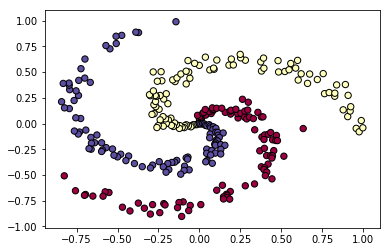

In [89]:
# Test using following
# http://cs231n.github.io/neural-networks-case-study/
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral,
           edgecolors='black')
plt.show()

y = np.eye(np.max(y) + 1)[y]

## Debugging
Only seems to work like i'm expecting for one layer case.

In [84]:
test = Network([X.shape[1], 5, 3, y.shape[1]], ["sigmoid", "relu"])

In [70]:
h, z = test.model_forward(X)

# compare with manual values
z_1 = X.dot(test.W[0].T) + test.b[0].T
h_1 = test.sigmoid(z_1)
z_2 = h_1.dot(test.W[1].T) + test.b[1].T
h_2 = test.relu(z_2)
z_3 = h_2.dot(test.W[2].T) + test.b[2].T
h_3 = test.softmax(z_3)

In [81]:
h[3]

array([[0.34556524, 0.31424912, 0.34018563],
       [0.34556398, 0.31424859, 0.34018743],
       [0.34556277, 0.31424804, 0.34018919],
       [0.34556107, 0.31424759, 0.34019134],
       [0.34555991, 0.31424703, 0.34019306],
       [0.34555959, 0.31424636, 0.34019405],
       [0.34555994, 0.31424573, 0.34019434],
       [0.34555704, 0.31424528, 0.34019768],
       [0.34555782, 0.3142446 , 0.34019758],
       [0.34555989, 0.31424408, 0.34019603],
       [0.34555849, 0.31424348, 0.34019802],
       [0.34555724, 0.3142429 , 0.34019985],
       [0.34555868, 0.31424243, 0.34019888],
       [0.34555127, 0.31424187, 0.34020686],
       [0.34555073, 0.31424128, 0.34020799],
       [0.34555958, 0.31424096, 0.34019946],
       [0.34556503, 0.31424115, 0.34019382],
       [0.34555554, 0.31423962, 0.34020484],
       [0.34554276, 0.31423943, 0.34021781],
       [0.34556547, 0.31423973, 0.3401948 ],
       [0.34556554, 0.31423925, 0.34019521],
       [0.34556037, 0.31423803, 0.34020161],
       [0.

In [71]:
np.array_equal(z_1, z[0])

True

In [72]:
np.array_equal(h_3, h[-1])

True

In [86]:
for i in range(test.num_layers - 2, -1, -1):
    print(i)

1
0


In [90]:
test.L_model_backward(y, z, h)

AssertionError: ERROR: h_prev.shape != dh_prev.shape

### Model forward works good
Now we have the issue of backpass :(

In [45]:
# step 1
g_L = (h_3 - y)/y.shape[0]
# first backprop
dW_L = h_2.T.dot(g_L)
db_L = g_L.mean(axis = 0).reshape(test.b[-1].shape)
dhidden_3 = g_L.dot(test.W[-1])

In [437]:
test = Network([X.shape[1], 50, 10, y.shape[1]], ["relu", "sigmoid"])
res = test.train_L_layer_model(X, y, epochs = 1000)

Cost iter 0: 1.111
Cost iter 100: 1.098
Cost iter 200: 1.097
Cost iter 300: 1.097
Cost iter 400: 1.097
Cost iter 500: 1.097
Cost iter 600: 1.096
Cost iter 700: 1.096
Cost iter 800: 1.095
Cost iter 900: 1.095


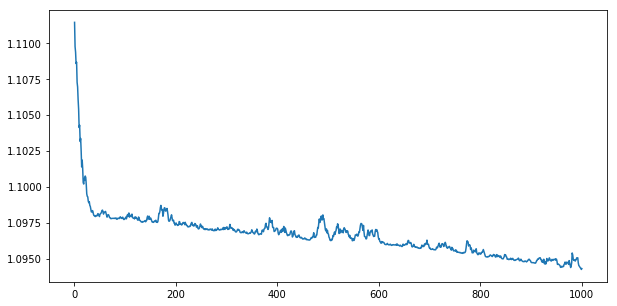

In [438]:
plt.plot(np.linspace(1, res[0].size, res[0].size), res[0])

In [349]:
# With test and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

net = Network([X_train.shape[1], 50, 10, y.shape[1]], ["relu", "sigmoid"])
res = net.train_L_layer_model(X_train, y_train, epochs = 1000, 
                              test_data = [X_test, y_test], step_size = 0.1)

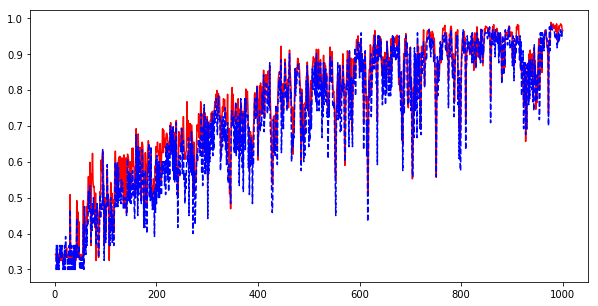

In [350]:
plt.plot(np.linspace(1, res[0].size, res[0].size), res[1], "r")
plt.plot(np.linspace(1, res[0].size, res[0].size), res[2], "--b")

# Trying the MNIST data

In [351]:
from scipy import misc
import glob
import os
def load_mnist(path_to_MNIST):
    # Loads the MNIST dataset from png images
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        # the + str(label) didnt work for me
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Test", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob(os.path.join(path_to_MNIST, "MNIST\\Train", str(label) + "\\*.png")):
            image = misc.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_mnist("C:\\Users\\lukar818\\Desktop")

In [353]:
X_train, Y_train, X_test, Y_test = load_mnist("C:\\Users\\lukar818\\Desktop")

C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [354]:
Y_train.shape

(60000, 10)

In [426]:
mnist_net = Network([X_train.shape[1], Y_train.shape[1]], "Softmax")
mnist_result = mnist_net.train_L_layer_model(X_train, Y_train, 
                                             epochs = 3000, test_data = [X_test, Y_test],
                                             step_size = .1)

Cost iter 0: 35.323
Cost iter 100: 20.204
Cost iter 200: 6.048
Cost iter 300: 4.288
Cost iter 400: 3.136
Cost iter 500: 2.880
Cost iter 600: 4.426
Cost iter 700: 3.728
Cost iter 800: 2.991
Cost iter 900: 7.025
Cost iter 1000: 4.390
Cost iter 1100: 2.413
Cost iter 1200: 2.403
Cost iter 1300: 2.332
Cost iter 1400: 2.668
Cost iter 1500: 8.875
Cost iter 1600: 2.751
Cost iter 1700: 2.607
Cost iter 1800: 2.887
Cost iter 1900: 2.780
Cost iter 2000: 1.979
Cost iter 2100: 2.164
Cost iter 2200: 2.433
Cost iter 2300: 1.902
Cost iter 2400: 2.986
Cost iter 2500: 2.875
Cost iter 2600: 1.687
Cost iter 2700: 1.749
Cost iter 2800: 8.204
Cost iter 2900: 3.040


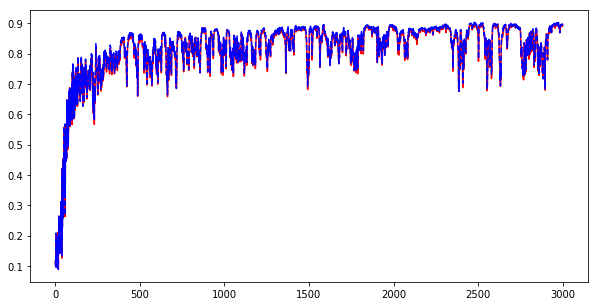

In [427]:
plt.plot(np.linspace(1, mnist_result[0].size, mnist_result[0].size), mnist_result[1], "r")
plt.plot(np.linspace(1, mnist_result[0].size, mnist_result[0].size), mnist_result[2], "--b")

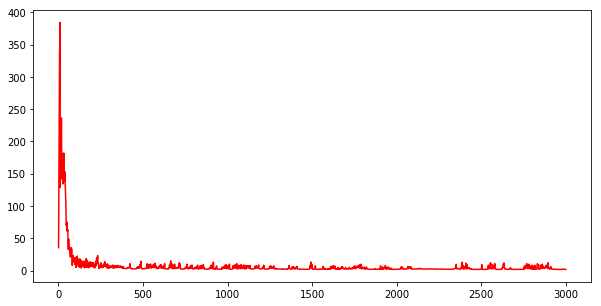

In [428]:
plt.plot(np.linspace(1, mnist_result[0].size, mnist_result[0].size), mnist_result[0], "r")

In [430]:
mnist_result[2][-1]

0.8916

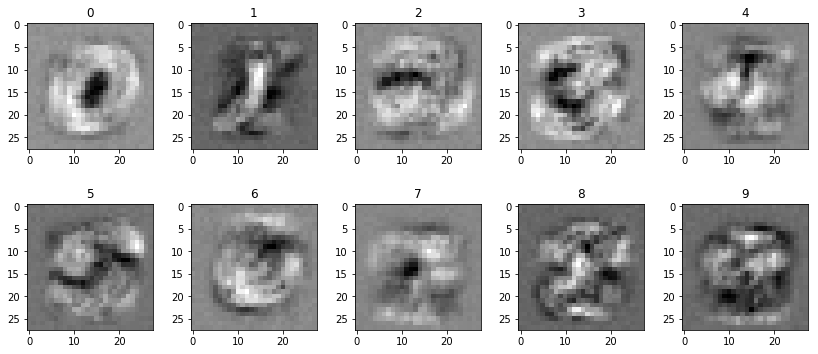

In [429]:
fig, axs = plt.subplots(2,5, figsize=(14, 10), edgecolor='k')
fig.subplots_adjust(hspace = -.5, wspace=.3)

axs = axs.ravel()

for i in range(10):
    axs[i].imshow(mnist_net.W[0][i, :].reshape(28, 28), cmap = 'gray')
    axs[i].set_title(str(i))
for a in axs:
    a.set_aspect('equal')


In [434]:
mnist_net_L = Network([X_train.shape[1], 100, Y_train.shape[1]], "relu")
mnist_result_L = mnist_net_L.train_L_layer_model(X_train, Y_train, epochs = 100, test_data = [X_test, Y_test])

Cost iter 0: 55.475


C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log
C:\Users\lukar818\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: 

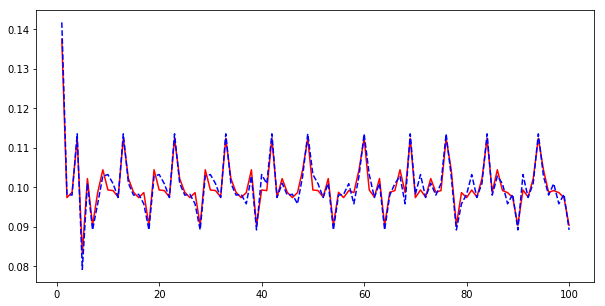

In [432]:
plt.plot(np.linspace(1, mnist_result_L[0].size, mnist_result_L[0].size), mnist_result_L[1], "r")
plt.plot(np.linspace(1, mnist_result_L[0].size, mnist_result_L[0].size), mnist_result_L[2], "--b")

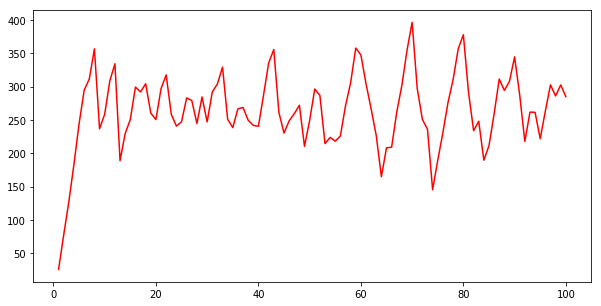

In [433]:
plt.plot(np.linspace(1, mnist_result_L[0].size, mnist_result_L[0].size), mnist_result_L[0], "r")